In [1]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from deep_generalizability.nets import Nets
from deep_generalizability.utils import *
from deep_generalizability.postprocessing.postprocessing import *
from deep_generalizability.postprocessing.stats_plotting import *
from deep_generalizability.save_load import *

from deep_generalizability.postprocessing.sharpness_measures import *
from deep_generalizability.postprocessing.stats_plotting import *

from deep_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


In [93]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "concentric_balls"
exp = "Sep03_19-07-02_Daniels-MacBook-Pro-4.local"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [94]:
stats_df = get_end_stats(experiment_folder)


In [95]:
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Gap Mean,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Loss Test Max,Loss Test Mean,Loss Test Min,Loss Train Max,Loss Train Mean,Loss Train Min,Norm Max,Norm Mean,Norm Min
1599152830.026554,0.004,0.95,0.95,0.95,0.946,0.946,0.946,0.181,0.181,0.181,0.189398,0.189398,0.189398,14.800916,14.800916,14.800916


In [96]:
all_models = get_all_models(experiment_folder, -1)

In [103]:
m = all_models["1599152830.026554"]["0"]

In [111]:
m.state_dict()

OrderedDict([('fc_input.weight', tensor([[ 2.6572,  2.9194],
                      [-1.9558, -3.6726]])),
             ('fc_input.bias', tensor([1.9195, 2.2298])),
             ('layers.0.weight', tensor([[2.4225, 2.2552],
                      [0.7905, 0.7359]])),
             ('layers.0.bias', tensor([-12.0818,  -3.9423])),
             ('fc_final.weight', tensor([[-0.9907, -0.3865],
                      [ 0.0237, -0.0556]])),
             ('fc_final.bias', tensor([ 1.5299, -0.8261]))])

In [104]:
def last_layer_net(m):
    new_m = copy.deepcopy(m)
    
    new_param_dict = dict(new_m.state_dict())
    new_final_weight = torch.eye(new_param_dict['fc_final.weight'].shape[1])
    new_final_bias =  torch.zeros(new_param_dict['fc_final.weight'].shape[1])
    
    new_param_dict['fc_final.weight'].data.copy_(new_final_weight)
    new_param_dict['fc_final.bias'].data.copy_(new_final_bias)

    return new_m

new_m = last_layer_net(m)

In [105]:
train_data, test_data = get_data_for_experiment(experiment_folder)


In [106]:
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_batch = iter(train_loader).next()

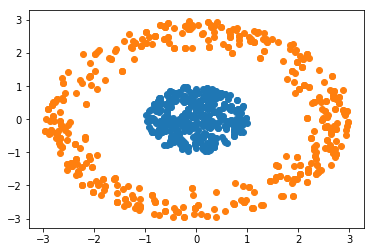

In [107]:
inputs, labels = train_batch
out_data = new_m(inputs)

np_inputs = inputs.detach().numpy()

plt.scatter(x=np_inputs[:, 0][class_filter], y=np_inputs[:, 1][class_filter])
plt.scatter(x=np_inputs[:, 0][~class_filter], y=np_inputs[:, 1][~class_filter])


In [108]:
out_data_np

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

(0, 2)

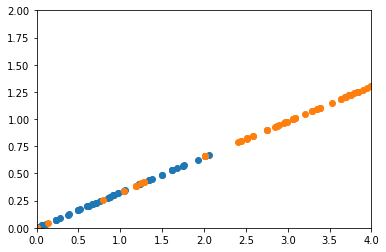

In [110]:
out_data_np = out_data.detach().numpy()
class_filter = (labels == 0).detach().numpy()
plt.scatter(out_data_np[:, 0][class_filter], out_data_np[:, 1][class_filter])
plt.scatter(out_data_np[:, 0][~class_filter], out_data_np[:, 1][~class_filter])
plt.xlim(0, 4)
plt.ylim(0, 2)